<a href="https://colab.research.google.com/github/alfahimmohammad/MC-DDPM/blob/main/notebooks/quick_start_with_hugging_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

~~~
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~
<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/cxr-foundation/blob/master/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/cxr-foundation/blob/master/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/cxr-foundation">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
</tr></tbody></table>

# Quick start with Hugging Face
This Colab notebook provides a basic demo of using Chest X-ray (CXR) Foundation. CXR Foundation is an embeddings models that generates a machine learning representations known as embeddings, from chest X-ray images and/or chest X-ray related text. These embeddings can be used to develop custom models for CXR use-cases with less data and compute compared to traditional model development methods. Learn more about embeddings and their benefits at this [page](https://developers.google.com/health-ai-developer-foundations/cxr-foundation).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# @title Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder
from huggingface_hub import notebook_login

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
# @title Helper Functions to prepare inputs: text & image TF Example
!pip install numpy==1.26.4 tensorflow-text==2.17 pypng 2>&1 1>/dev/null
import io
import png
import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_hub as tf_hub
import numpy as np

# Helper function for tokenizing text input
def bert_tokenize(text):
    """Tokenizes input text and returns token IDs and padding masks."""
    preprocessor = tf_hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    out = preprocessor(tf.constant([text.lower()]))
    ids = out['input_word_ids'].numpy().astype(np.int32)
    masks = out['input_mask'].numpy().astype(np.float32)
    paddings = 1.0 - masks
    end_token_idx = ids == 102
    ids[end_token_idx] = 0
    paddings[end_token_idx] = 1.0
    ids = np.expand_dims(ids, axis=1)
    paddings = np.expand_dims(paddings, axis=1)
    assert ids.shape == (1, 1, 128)
    assert paddings.shape == (1, 1, 128)
    return ids, paddings

# Helper function for processing image data
def png_to_tfexample(image_array: np.ndarray) -> tf.train.Example:
    """Creates a tf.train.Example from a NumPy array."""
    # Convert the image to float32 and shift the minimum value to zero
    image = image_array.astype(np.float32)
    image -= image.min()

    if image_array.dtype == np.uint8:
        # For uint8 images, no rescaling is needed
        pixel_array = image.astype(np.uint8)
        bitdepth = 8
    else:
        # For other data types, scale image to use the full 16-bit range
        max_val = image.max()
        if max_val > 0:
            image *= 65535 / max_val  # Scale to 16-bit range
        pixel_array = image.astype(np.uint16)
        bitdepth = 16

    # Ensure the array is 2-D (grayscale image)
    if pixel_array.ndim != 2:
        raise ValueError(f'Array must be 2-D. Actual dimensions: {pixel_array.ndim}')

    # Encode the array as a PNG image
    output = io.BytesIO()
    png.Writer(
        width=pixel_array.shape[1],
        height=pixel_array.shape[0],
        greyscale=True,
        bitdepth=bitdepth
    ).write(output, pixel_array.tolist())
    png_bytes = output.getvalue()

    # Create a tf.train.Example and assign the features
    example = tf.train.Example()
    features = example.features.feature
    features['image/encoded'].bytes_list.value.append(png_bytes)
    features['image/format'].bytes_list.value.append(b'png')

    return example

# Compute Embeddings

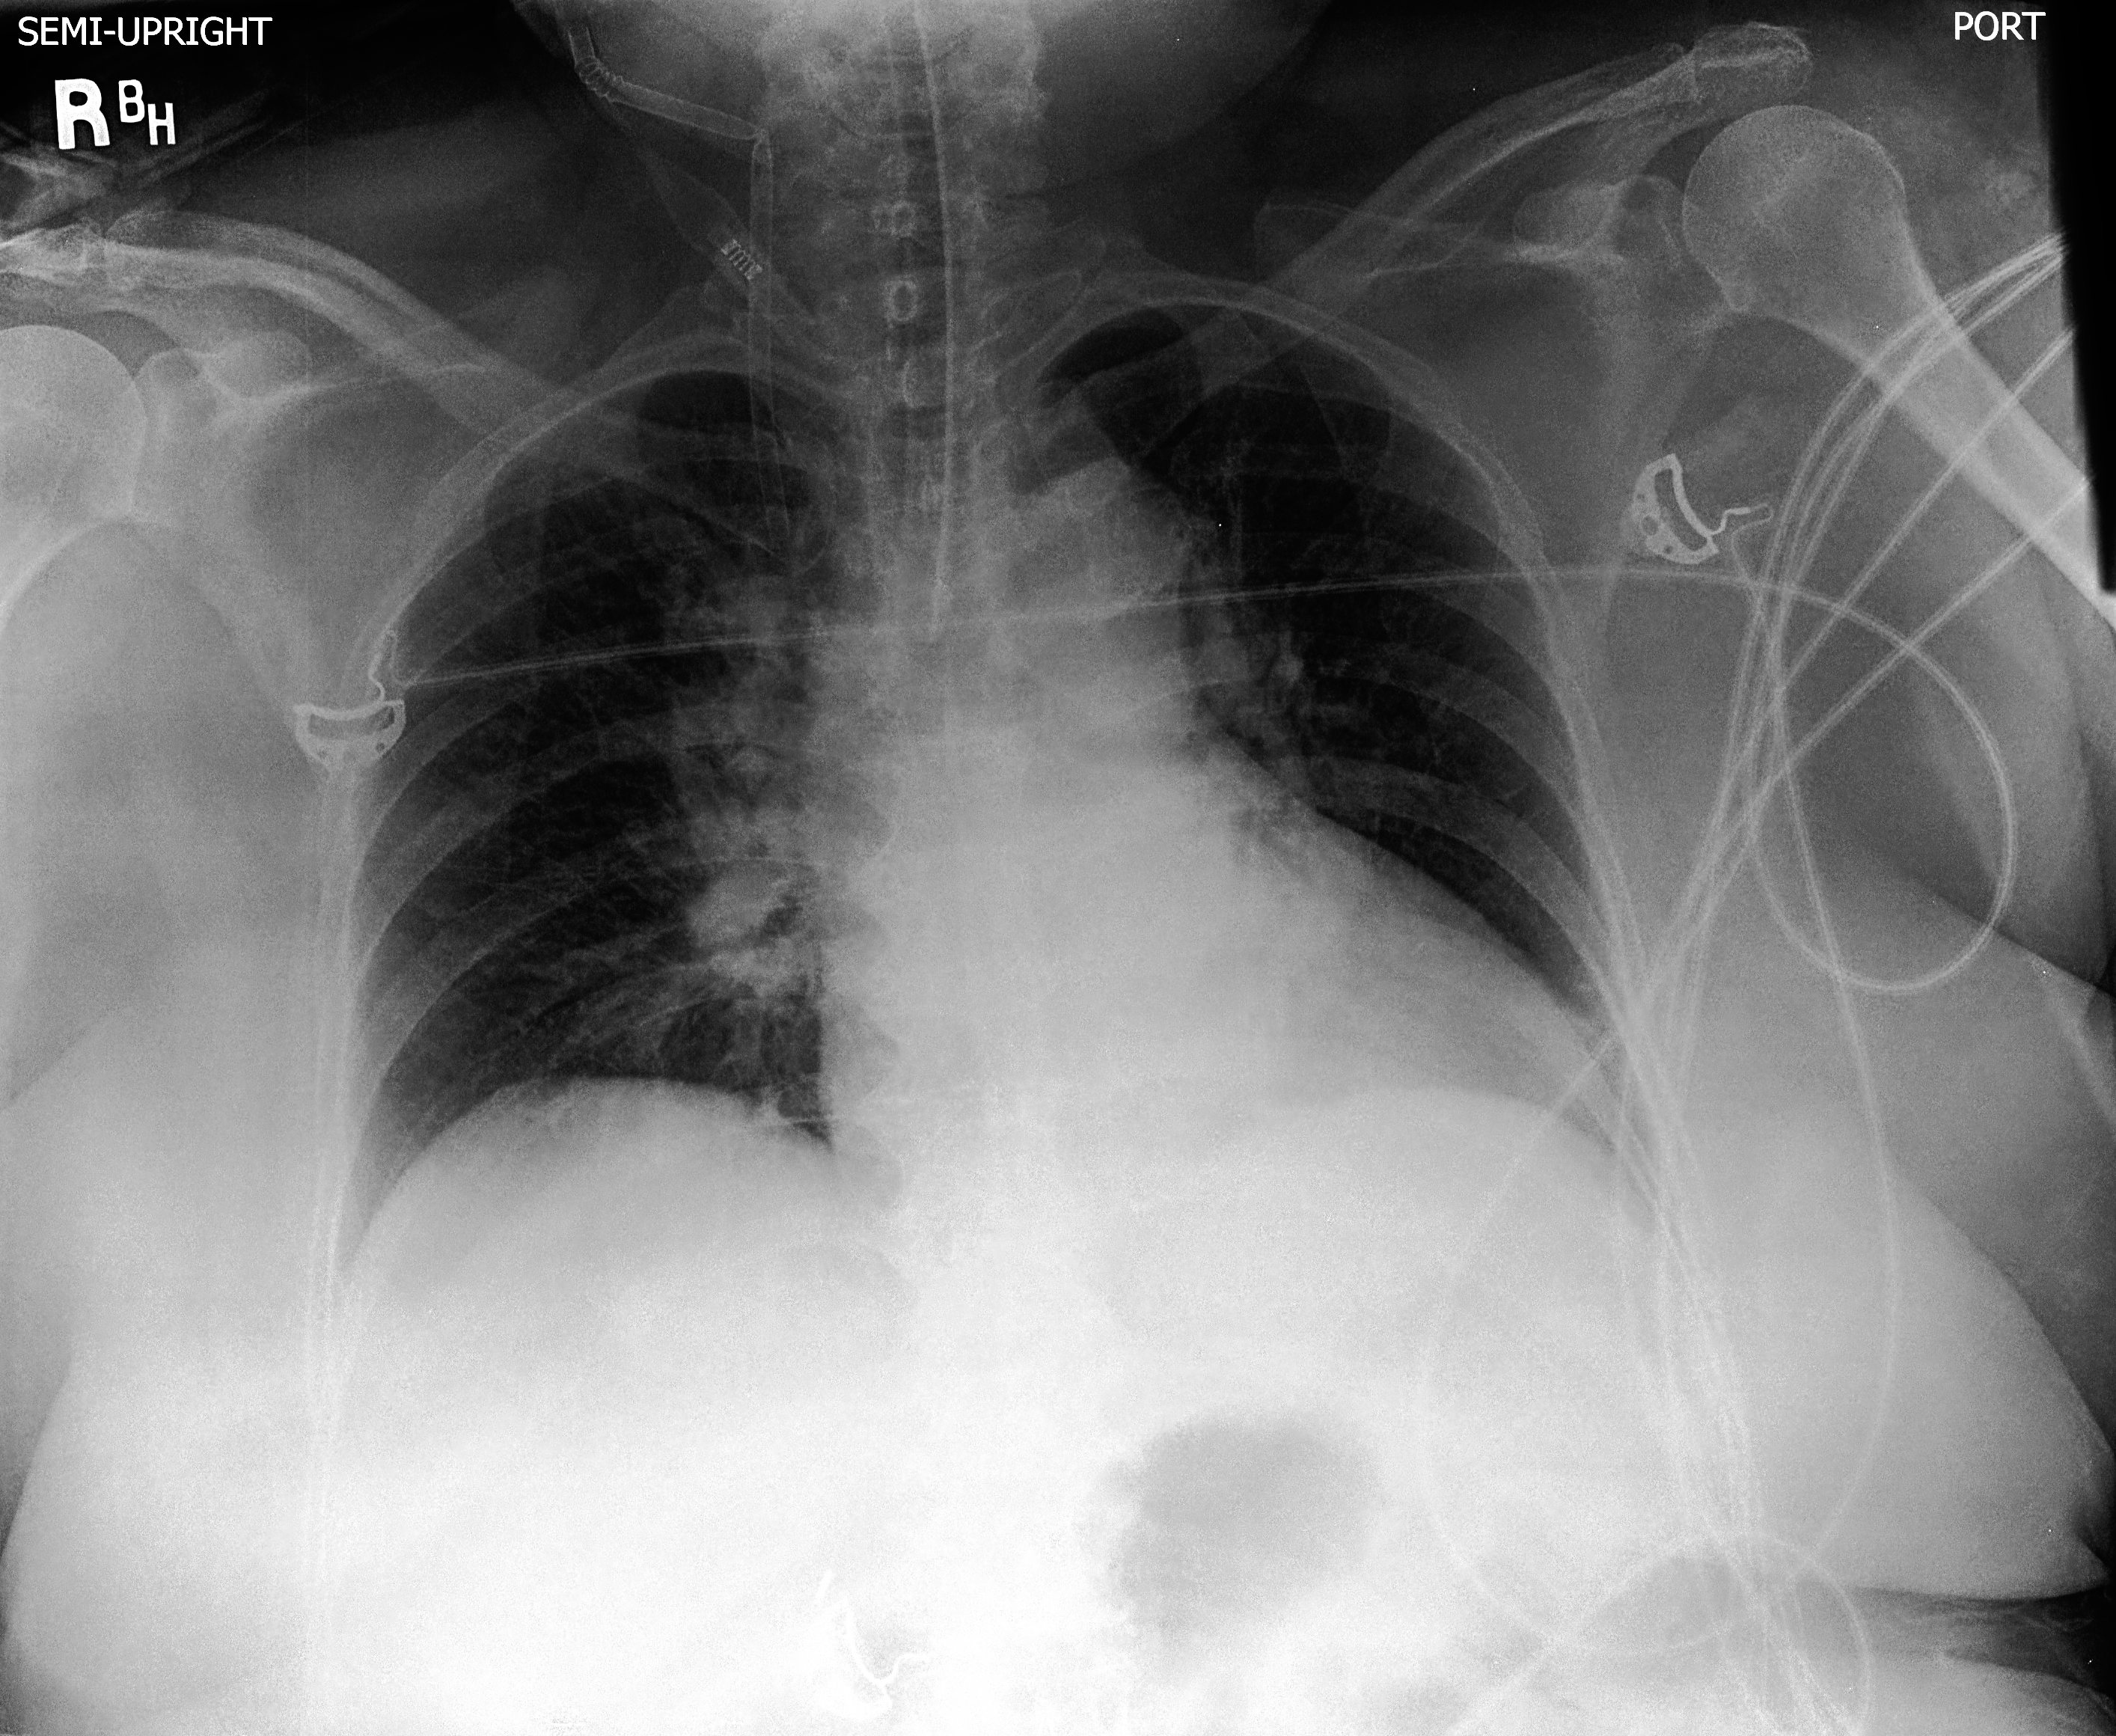

In [3]:
# @title Fetch Sample Image
from PIL import Image
from IPython.display import Image as IPImage, display
# Image attribution: Stillwaterising, CC0, via Wikimedia Commons
!wget -nc -q https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png
display(IPImage(filename="/content/drive/MyDrive/chest_xrays/view1_frontal.png", height=300))
img = Image.open("/content/drive/MyDrive/chest_xrays/view1_frontal.png").convert('L')
# img = Image.open("Chest_Xray_PA_3-8-2010.png").convert('L')  # Convert to grayscale

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/6.89M [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/9.17M [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/5.91k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/724M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

ELIXR-C - interim embedding shape:  (1, 8, 8, 1376)
ELIXR-B - embedding shape:  (1, 32, 128)


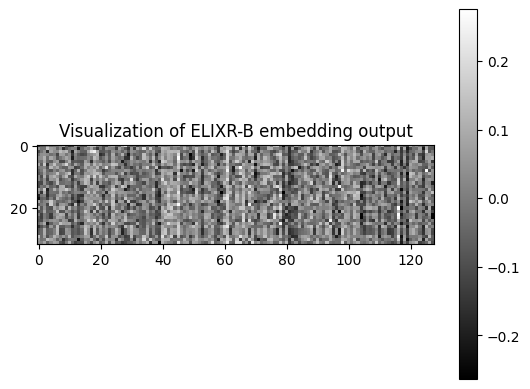

In [4]:
# @title Invoke Model with Image
import logging
import numpy as np
import matplotlib.pyplot as plt
tf.get_logger().setLevel(logging.ERROR)

# Download the model repository files
from huggingface_hub import snapshot_download
snapshot_download(repo_id="google/cxr-foundation",local_dir='/content/hf',
                  allow_patterns=['elixr-c-v2-pooled/*', 'pax-elixr-b-text/*'])

# Step 1 - ELIXR C (image to elixr C embeddings)
serialized_img_tf_example = png_to_tfexample(np.array(img)).SerializeToString()

if 'elixrc_model' not in locals():
  elixrc_model = tf.saved_model.load('/content/hf/elixr-c-v2-pooled')
  elixrc_infer = elixrc_model.signatures['serving_default']

elixrc_output = elixrc_infer(input_example=tf.constant([serialized_img_tf_example]))
elixrc_embedding = elixrc_output['feature_maps_0'].numpy()

print("ELIXR-C - interim embedding shape: ", elixrc_embedding.shape)

# Step 2 - Invoke QFormer with Elixr-C embeddings
# Initialize text inputs with zeros
qformer_input = {
    'image_feature': elixrc_embedding.tolist(),
    'ids': np.zeros((1, 1, 128), dtype=np.int32).tolist(),
    'paddings':np.zeros((1, 1, 128), dtype=np.float32).tolist(),
}

if 'qformer_model' not in locals():
  qformer_model = tf.saved_model.load("/content/hf/pax-elixr-b-text")

qformer_output = qformer_model.signatures['serving_default'](**qformer_input)
elixrb_embeddings = qformer_output['all_contrastive_img_emb']

print("ELIXR-B - embedding shape: ", elixrb_embeddings.shape)

# Plot output
plt.imshow(elixrb_embeddings[0], cmap='gray')
plt.colorbar()  # Show a colorbar to understand the value distribution
plt.title('Visualization of ELIXR-B embedding output')
plt.show()


In [5]:
# @title Input Text Query
# TEXT_QUERY = "Airspace opacity" # @param {type:"string"}
TEXT_QUERY = "Endotracheal tube malpositioned"

In [6]:
# @title Invoke Model with Text
import numpy as np

# Download the model repository files
from huggingface_hub import snapshot_download
snapshot_download(repo_id="google/cxr-foundation",local_dir='/content/hf',
                  allow_patterns=['elixr-c-v2-pooled/*', 'pax-elixr-b-text/*'])

# Run QFormer with text only.
# Initialize image input with zeros
tokens, paddings = bert_tokenize(TEXT_QUERY)
qformer_input = {
    'image_feature': np.zeros([1, 8, 8, 1376], dtype=np.float32).tolist(),
    'ids': tokens.tolist(),
    'paddings': paddings.tolist(),
}

if 'qformer_model' not in locals():
  qformer_model = tf.saved_model.load("/content/hf/pax-elixr-b-text")

qformer_output = qformer_model.signatures['serving_default'](**qformer_input)
text_embeddings_pos = qformer_output['contrastive_txt_emb']

print("Text Embedding shape: ", text_embeddings_pos.shape)
print("First 5 tokens: ", text_embeddings_pos[0][0:5])


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Text Embedding shape:  (1, 128)
First 5 tokens:  tf.Tensor([ 0.12665644 -0.11373144  0.03043609 -0.04997201  0.01502208], shape=(5,), dtype=float32)


In [7]:
# @title Input Text Query
# TEXT_QUERY = "Airspace opacity" # @param {type:"string"}
TEXT_QUERY = "Endotracheal tube correclty positioned"

In [8]:
# @title Invoke Model with Text
import numpy as np

# Download the model repository files
from huggingface_hub import snapshot_download
snapshot_download(repo_id="google/cxr-foundation",local_dir='/content/hf',
                  allow_patterns=['elixr-c-v2-pooled/*', 'pax-elixr-b-text/*'])

# Run QFormer with text only.
# Initialize image input with zeros
tokens, paddings = bert_tokenize(TEXT_QUERY)
qformer_input = {
    'image_feature': np.zeros([1, 8, 8, 1376], dtype=np.float32).tolist(),
    'ids': tokens.tolist(),
    'paddings': paddings.tolist(),
}

if 'qformer_model' not in locals():
  qformer_model = tf.saved_model.load("/content/hf/pax-elixr-b-text")

qformer_output = qformer_model.signatures['serving_default'](**qformer_input)
text_embeddings_neg = qformer_output['contrastive_txt_emb']

print("Text Embedding shape: ", text_embeddings_neg.shape)
print("First 5 tokens: ", text_embeddings_neg[0][0:5])


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Text Embedding shape:  (1, 128)
First 5 tokens:  tf.Tensor([-0.22278687 -0.08347818 -0.06561497 -0.06691986 -0.05620323], shape=(5,), dtype=float32)


In [9]:
elixrb_embeddings.shape

TensorShape([1, 32, 128])

In [10]:
# @title Similarity and Zero-shot Classification Functions

import numpy as np

diagnosis_columns = ['ETT']

def softmax(x):
    """Calculates the softmax of a list of numbers."""
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / exp_x.sum(axis=0)

def compute_image_text_similarity(image_emb, txt_emb):
  image_emb = np.reshape(image_emb, (32, 128))
  similarities = []
  for i in range(32):
    # cosine similarity
    similarity = np.dot(image_emb[i], txt_emb)/(np.linalg.norm(image_emb[i]) * np.linalg.norm(txt_emb))
    similarities.append(similarity)
  np_sm_similarities = np.array((similarities))
  return np.max(np_sm_similarities)

def zero_shot(image_emb, pos_txt_emb,neg_txt_emb):
  pos_cosine = compute_image_text_similarity(image_emb, pos_txt_emb)
  neg_cosine = compute_image_text_similarity(image_emb, neg_txt_emb)
  return pos_cosine - neg_cosine

def get_text_embeddings_for_diagnosis(diagnosis):
  """
  This function takes a diagnosis as input and outputs the positive and negative text queries.
  """
  column_to_pos_neg = {
      'ETT': ('Endotracheal tube malpositioned', 'Endotracheal tube correclty positioned'),
  }

  pos_txt, neg_txt = column_to_pos_neg[diagnosis]


  return pos_txt, neg_txt

def compute_similarity_scores(eval_data_df, pos_txt, neg_txt):
  pos_txt_emb = text_embeddings_df.set_index('query').loc[pos_txt, 'embeddings']
  neg_txt_emb = text_embeddings_df.set_index('query').loc[neg_txt, 'embeddings']

  # Iterate over each image_id in eval_data_df
  for index, row in eval_data_df.iterrows():
    image_id = row['image_id']
    # Get the embedding for the current image_id from image_embeddings_df
    image_embedding = image_embeddings_df[image_embeddings_df['image_id'] == image_id]['embeddings'].iloc[0]
    # Compute the similarity using the zero_shot function
    similarity_score = zero_shot(image_embedding, pos_txt_emb, neg_txt_emb)
    # Store the similarity score in a new column named 'score'
    eval_data_df.loc[index, 'score'] = similarity_score


In [12]:
score = zero_shot(elixrb_embeddings, text_embeddings_pos[0], text_embeddings_neg[0])
print(score)

-0.090084374


# Next steps

Explore the other [notebooks](https://github.com/google-health/cxr-foundation/blob/master/notebooks) to learn what else you can do with the model.